# Baseline algorithms for early warning systems

In [1]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta, date
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import calplot
import time
import math
import json
import sys
import os

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [4]:
from helpers.db_connector import MySQLConnector
from helpers.feature_extraction import *
from helpers.data_process import *
from helpers.db_query import *
from helpers.time import *

## Linear Algebra Dataset from Coursaware

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2017-2018**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [5]:
%time user_data = getUserInfo()

Wall time: 1min 19s


The initial data of volunteers was cleaned, and some participants were removed before we analyzed the data:
- The volunteering students who have not been graded were removed. 
- The repeating students were filtered out, where repeating students are those accessing videos in two different years. 
- The less active students, i.e., those who have provided less 60 interactions in the platform, were removed. 

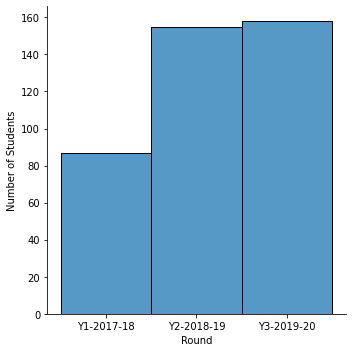

In [6]:
sns.displot(user_data, x='Round')
plt.ylabel('Number of Students')
plt.show()

In [7]:
user_data.head()

,AccountUserID,SCIPER,Round
0,10547,284707,Y1-2017-18
1,10031,288415,Y1-2017-18
2,9734,288078,Y1-2017-18
3,10615,283672,Y1-2017-18
5,9893,287261,Y1-2017-18


**N.B.** We are missing a range of important demographic attributes, such as the gender, the age, and the prior knowledge.

### Getting Students' Records

#### Video Clickstream Records

In [8]:
%time video_data = getVideoEventsInfo().drop_duplicates(keep='first').reset_index(drop=True)

Wall time: 2min 7s


In [18]:
video_data.head()

,AccountUserID,ElementID,EventType,TimeStamp,Round,Title,Source
0,95017,ca2fa02b0daa43f295e76da61e53de2a,Video.Play,1570355725,Y3-2019-20,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY
1,95017,ca2fa02b0daa43f295e76da61e53de2a,Video.Play,1570355899,Y3-2019-20,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY
2,95017,ca2fa02b0daa43f295e76da61e53de2a,Video.Play,1570355940,Y3-2019-20,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY
3,95017,ca2fa02b0daa43f295e76da61e53de2a,Video.Pause,1570355694,Y3-2019-20,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY
4,95017,ca2fa02b0daa43f295e76da61e53de2a,Video.Pause,1570355760,Y3-2019-20,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY


#### Problem Clickstream Records

In [10]:
%time problem_data = getProblemEventsInfo()

Wall time: 1min 17s


In [17]:
problem_data.head()

,AccountUserID,ElementID,EventType,TimeStamp,ProblemType,MaximumSubmissions,Round
0,46461,44c46d58e2eb440b9308893be55aae3c,Problem.Check,1543677480,Quiz,1.0,Y2-2018-19
1,46461,ca64971b751847c798f5ff753e3eddfe,Problem.Check,1547885100,Quiz,NaN,Y2-2018-19
2,46461,b31684ee6a684d12ba0f4afc51fe0ca4,Problem.Check,1544256079,Quiz,NaN,Y2-2018-19
3,46461,6983ed426ef14e41900f72b155f3444e,Problem.Check,1541263833,Quiz,1.0,Y2-2018-19
4,46461,1d5df58214374b80974bf8776313e3fc,Problem.Check,1540406407,Quiz,NaN,Y2-2018-19


#### Exam Records

In [19]:
%time exam_data = getExamInfo()

Wall time: 599 ms


We filter the exam records of students who have not participated into the study

In [20]:
exam_data = exam_data[exam_data['AccountUserID'].isin(user_data['AccountUserID'])]

In [21]:
exam_data.head()

,Grade,GradeDate,Round,AccountUserID
0,5.00,02.2019,Y2-2018-19,46938
1,4.25,02.2018,Y1-2017-18,8402
2,3.25,02.2018,Y1-2017-18,9866
3,5.50,02.2019,Y2-2018-19,49638
4,3.75,02.2018,Y1-2017-18,11354


#### Identify Target Round Data

In [165]:
with open('../config/linear_algebra.json') as f:
    config = json.load(f)

In [166]:
tround = 'Y3-2019-20'

In [167]:
user_data_round = user_data[user_data['Round'] == tround]

In [168]:
video_data_round = video_data[video_data['Round'] == tround]

In [169]:
problem_data_round = problem_data[problem_data['Round'] == tround]

In [170]:
exam_data_round = exam_data[exam_data['Round'] == tround]

#### Event Records

In [171]:
d1 = video_data_round[['AccountUserID', 'ElementID', 'TimeStamp', 'EventType', 'Round']]
d2 = problem_data_round[['AccountUserID', 'ElementID', 'TimeStamp', 'EventType', 'Round']]

data = d1.append(d2)

Drop outsiders not between start and end date

In [172]:
data['Date'] = data['TimeStamp'].apply(lambda x:string2Datetime(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))

In [173]:
data = dropDateOutsiders(data, 'Date', config[tround]['Start'], config[tround]['End'])

In [174]:
data.head()

,AccountUserID,ElementID,TimeStamp,EventType,Round,Date
0,95017,ca2fa02b0daa43f295e76da61e53de2a,1570355725,Video.Play,Y3-2019-20,2019-10-06 09:55:25
1,95017,ca2fa02b0daa43f295e76da61e53de2a,1570355899,Video.Play,Y3-2019-20,2019-10-06 09:58:19
2,95017,ca2fa02b0daa43f295e76da61e53de2a,1570355940,Video.Play,Y3-2019-20,2019-10-06 09:59:00
3,95017,ca2fa02b0daa43f295e76da61e53de2a,1570355694,Video.Pause,Y3-2019-20,2019-10-06 09:54:54
4,95017,ca2fa02b0daa43f295e76da61e53de2a,1570355760,Video.Pause,Y3-2019-20,2019-10-06 09:56:00


#### Identify Week

In [175]:
data = processWeek(data, 'Date', config[tround]['Start'])

In [176]:
data['Week'] = data['Week'].apply(lambda x: int(x))

In [177]:
data.head()

,AccountUserID,ElementID,TimeStamp,EventType,Round,Date,Week
77062,90044,4fe3df7b0c064bf2b68d7bcbe2663743,1568612745,Video.Transcript.Translate.EN,Y3-2019-20,2019-09-16 05:45:45,0
77064,90044,4fe3df7b0c064bf2b68d7bcbe2663743,1568612746,Video.Load,Y3-2019-20,2019-09-16 05:45:46,0
250835,90044,2ae6c4de2fbd4d5c8267795a5d572b6e,1568612869,Problem.Reset,Y3-2019-20,2019-09-16 05:47:49,0
251275,90044,2ae6c4de2fbd4d5c8267795a5d572b6e,1568612869,Problem.Reset,Y3-2019-20,2019-09-16 05:47:49,0
251504,90044,2ae6c4de2fbd4d5c8267795a5d572b6e,1568612869,Problem.Reset,Y3-2019-20,2019-09-16 05:47:49,0


## Train-Test Data Split

In [220]:
x = exam_data_round['AccountUserID'].values
y = [(1 if grade >= 4.0 else 0) for grade in exam_data_round['Grade']]

In [221]:
'Pass', y.count(1), 'Fail', y.count(0)

('Pass', 103, 'Fail', 55)

In [222]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.30)

In [223]:
'Train Pass', y_train.count(1), 'Test Pass', y_test.count(1), 'Train Fail', y_train.count(0), 'Test Fail', y_test.count(0)

('Train Pass', 72, 'Test Pass', 31, 'Train Fail', 38, 'Test Fail', 17)

## Baseline Feature Extractors

In [224]:
class Extractor():   
    
    def __init__(self, name='base'):
        self.name = name
    
    def getName(self):
        return self.name
    
    def getTotalEvent(self, udata, event_type, unique=False):
        edata = udata[udata['EventType'] == event_type]
        return len(edata) if not unique else len(edata.drop_duplicates(subset=['ElementID'], keep='first'))

class LemayDoleck(Extractor):
    
    def __init__(self):
        super().__init__('lamay_doleck')
        
    def getUserFeatures(self, udata):
        return [
            self.getTotalEvent(udata, 'Video.Play', unique=True),
            self.getTotalEvent(udata, 'Video.Pause'),
            self.getTotalEvent(udata, 'Video.Seek'),
            self.getTotalEvent(udata, 'Video.SpeedChange'),
        ]

In [225]:
week_thresholds = np.arange(4, 24, 4)

In [226]:
feature_labels = {
    LemayDoleck(),
}

In [227]:
feature_sets = {} 
for ffunc in feature_labels:
    flabel = ffunc.getName()
    feature_sets[flabel] = {}
    for wid in week_thresholds:
        feature_sets[flabel][wid] = {}
        feature_sets[flabel][wid]['train'] = []
        feature_sets[flabel][wid]['test'] = []
        scaler = StandardScaler()
        for uindex, uid in enumerate(x_train): 
            print('\r', 'Set:', flabel, '\tWeek:', wid, '\tMode: train', '\tProgress:', uindex + 1, len(x_train), end='')
            udata = data[(data['AccountUserID'] == uid) & (data['Week'] < wid)]
            feature_sets[flabel][wid]['train'].append(ffunc.getUserFeatures(udata))
        feature_sets[flabel][wid]['train'] = scaler.fit_transform(np.array(feature_sets[flabel][wid]['train']))
        print()
        for uindex, uid in enumerate(x_test): 
            print('\r', 'Set:', flabel, '\tWeek:', wid, '\tMode: test', '\tProgress:', uindex + 1, len(x_test), end='')
            udata = data[(data['AccountUserID'] == uid) & (data['Week'] < wid)]
            feature_sets[flabel][wid]['test'].append(ffunc.getUserFeatures(udata))
        feature_sets[flabel][wid]['test'] = scaler.fit_transform(np.array(feature_sets[flabel][wid]['test']))
        print()

 Set: lamay_doleck 	Week: 4 	Mode: train 	Progress: 110 110
 Set: lamay_doleck 	Week: 4 	Mode: test 	Progress: 48 48
 Set: lamay_doleck 	Week: 8 	Mode: train 	Progress: 110 110
 Set: lamay_doleck 	Week: 8 	Mode: test 	Progress: 48 48
 Set: lamay_doleck 	Week: 12 	Mode: train 	Progress: 110 110
 Set: lamay_doleck 	Week: 12 	Mode: test 	Progress: 48 48
 Set: lamay_doleck 	Week: 16 	Mode: train 	Progress: 110 110
 Set: lamay_doleck 	Week: 16 	Mode: test 	Progress: 48 48
 Set: lamay_doleck 	Week: 20 	Mode: train 	Progress: 110 110
 Set: lamay_doleck 	Week: 20 	Mode: test 	Progress: 48 48


## Baseline Predictive Models

- Check hyper-parameter
- Check number of users 18-19 (check weeks), 19-20

In [228]:
classifiers_types = {
    'ada': AdaBoostClassifier(),
    'dt': DecisionTreeClassifier(max_depth=5),
    'gnb': GaussianNB(),
    'lr': LogisticRegression(),
    'mlp': MLPClassifier(alpha=1, max_iter=1000),
    'knn': KNeighborsClassifier(3),
    'rf': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'svm': SVC(gamma=2, C=1)
}

In [229]:
trained_models = {}
for ffunc in feature_labels:
    flabel = ffunc.getName()
    trained_models[flabel] = {}
    for wid in week_thresholds:
        trained_models[flabel][wid] = {}
        print(flabel, wid, end='\t')
        for mid, clf in classifiers_types.items(): 
            print(mid, end=' ')
            trained_models[flabel][wid][mid] = clf.fit(feature_sets[flabel][wid]['train'], y_train)
        print()

lamay_doleck 4	ada dt gnb lr mlp knn rf svm 
lamay_doleck 8	ada dt gnb lr mlp knn rf svm 
lamay_doleck 12	ada dt gnb lr mlp knn rf svm 
lamay_doleck 16	ada dt gnb lr mlp knn rf svm 
lamay_doleck 20	ada dt gnb lr mlp knn rf svm 


## Baseline Evaluation Metrics

In [230]:
def tn(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[0]

def fp(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[1]

def fn(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[2]

def tp(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[3]

In [231]:
evaluation_metrics = {
    'acc': accuracy_score,
    'f1': f1_score,
    'p': precision_score, 
    'r': recall_score,
    'tp': tp,
    'tn': tn,
    'fp': fp,
    'fn': fn
}

In [232]:
results = {}
for ffunc in feature_labels:
    flabel = ffunc.getName()
    results[flabel] = {}
    for wid in week_thresholds:
        print(flabel, wid, end='\t')
        results[flabel][wid] = {}
        for mid, clf in classifiers_types.items(): 
            print(mid, end=' ')
            results[flabel][wid][mid] = {}
            for emid, mfunc in evaluation_metrics.items():
                results[flabel][wid][mid][emid] = mfunc(y_test, clf.predict(feature_sets[flabel][wid]['test']))
        print()

lamay_doleck 4	ada dt gnb lr mlp knn rf svm 
lamay_doleck 8	ada dt gnb lr mlp knn rf svm 
lamay_doleck 12	ada dt gnb lr mlp knn rf svm 
lamay_doleck 16	ada dt gnb lr mlp knn rf svm 
lamay_doleck 20	ada dt gnb lr mlp knn rf svm 


## Baseline Results Presentation

In [233]:
lst_data = []
lst_name = []
for flabel in results.keys():
    for wid in results[flabel].keys():
        for mid in results[flabel][wid].keys():
            lst_data.append([wid, flabel, mid] + [value for _, value in results[flabel][wid][mid].items()])  
            lst_name = ['week', 'set', 'clf'] + [emid for emid, _ in results[flabel][wid][mid].items()]

In [234]:
df_results = pd.DataFrame(lst_data, columns = lst_name)

In [235]:
df_results[df_results['week'] == 8].set_index(['week', 'set', 'clf'])

acc        f1         p         r  tp  tn  fp  fn
week set          clf                                                        
8    lamay_doleck ada  0.625000  0.727273  0.685714  0.774194  24   6  11   7
                  dt   0.500000  0.636364  0.600000  0.677419  21   3  14  10
                  gnb  0.666667  0.789474  0.666667  0.967742  30   2  15   1
                  lr   0.666667  0.794872  0.659574  1.000000  31   1  16   0
                  mlp  0.687500  0.800000  0.681818  0.967742  30   3  14   1
                  knn  0.479167  0.626866  0.583333  0.677419  21   2  15  10
                  rf   0.583333  0.705882  0.648649  0.774194  24   4  13   7
                  svm  0.562500  0.704225  0.625000  0.806452  25   2  15   6

In [236]:
df_results[df_results['week'] == 16].set_index(['week', 'set', 'clf'])

acc        f1         p         r  tp  tn  fp  fn
week set          clf                                                        
16   lamay_doleck ada  0.500000  0.636364  0.600000  0.677419  21   3  14  10
                  dt   0.437500  0.571429  0.562500  0.580645  18   3  14  13
                  gnb  0.625000  0.763158  0.644444  0.935484  29   1  16   2
                  lr   0.625000  0.769231  0.638298  0.967742  30   0  17   1
                  mlp  0.645833  0.779221  0.652174  0.967742  30   1  16   1
                  knn  0.520833  0.666667  0.605263  0.741935  23   2  15   8
                  rf   0.520833  0.666667  0.605263  0.741935  23   2  15   8
                  svm  0.562500  0.712329  0.619048  0.838710  26   1  16   5